In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

import torch
import numpy as np
import random

from internal.utils.ssim import ssim
from matplotlib import pyplot as plt
from gsplat.rasterize import rasterize_gaussians
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.dataparsers.colmap_block_dataparser import ColmapBlockParams, ColmapBlockDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [32]:
# load model and dataset
load_from = "../outputs/citygs2d_lfls_coarse_lnorm8_wo_vast_sepv2_debug/checkpoints/epoch=8-step=7000.ckpt"
model, renderer, _ = GaussianModelLoader.initialize_simplified_model_from_checkpoint(load_from, device="cuda")
if isinstance(renderer, VanillaTrimRenderer):
    model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)
    flatten_gs = True
else:
    flatten_gs = False
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapBlockDataParser(
    os.path.expanduser("../data/GauU_Scene/LFLS"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapBlockParams(
        split_mode="experiment",
        eval_image_select_mode="ratio",
        eval_ratio=0.1,
        down_sample_factor=3.4175,
    ),
).get_outputs()
print("Train camera count: {}".format(len(dataparser_outputs.train_set.cameras)))

Gaussian count: 2962513
appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 958, val set images: 120, loaded mask: 0
Train camera count: 958


In [33]:
ckpt = torch.load(load_from)["gaussian_model_extra_state_dict"]
max_radii2D, xyz_gradient_accum, denom = ckpt["max_radii2D"], ckpt["xyz_gradient_accum"], ckpt["denom"]
org_xyz = model._xyz.clone()

In [34]:
grad = (xyz_gradient_accum / denom).squeeze()
# grad = xyz_gradient_accum.squeeze()
# grad_mean = xyz_gradient_accum.mean()
# grad_std = xyz_gradient_accum.std()
# grad_mask = grad < grad_mean + grad_std * 3
grad_mask = grad < 0.0002
# grad_mask = torch.zeros_like(grad, dtype=torch.bool)
# grad_mask = (model.get_scaling[:, :2].min(dim=1)[0] / model.get_scaling[:, :2].max(dim=1)[0]) > 0.01
# model._scaling = model._scaling[:, [1,0,2]]
# model._xyz[~grad_mask] = org_xyz[~grad_mask].clone()
# model._xyz[~grad_mask] = model._xyz[~grad_mask] * 1.02
# model._scaling = model._scaling[:, [1,0,2]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image DJI_20240223163905_0040_Zenmuse-L1-mission.JPG


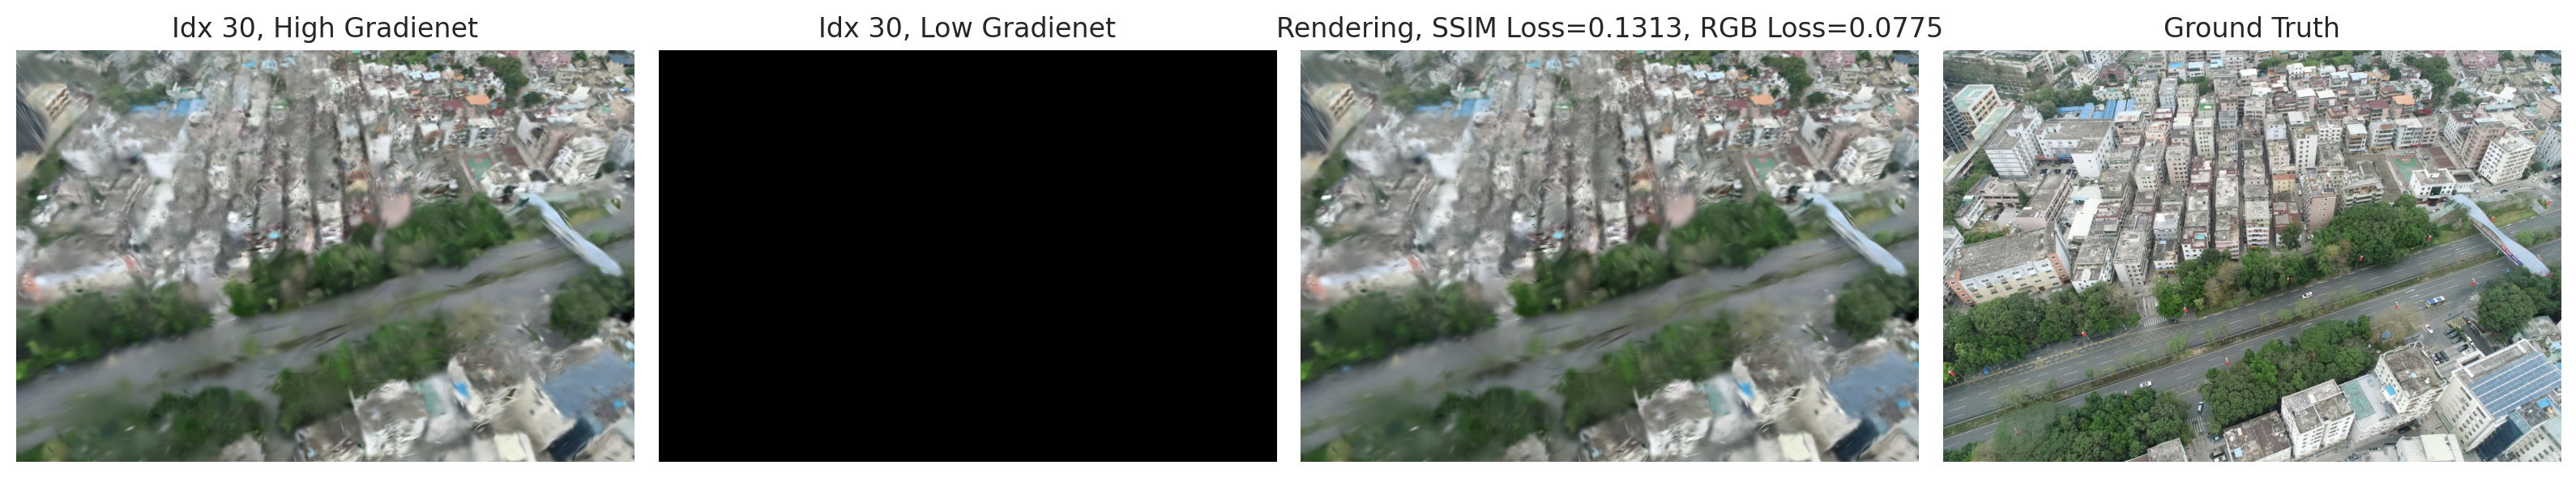

In [35]:
# Test image render
with torch.no_grad():
    # pick a camera
    # idx = random.randint(0, len(dataparser_outputs.train_set.cameras) - 1)
    idx = 30  # 30, 60, 90, 395
    camera = dataparser_outputs.train_set.cameras[idx].to_device("cuda")
    image_path = dataparser_outputs.train_set.image_paths[idx]
    gt = torch.tensor(plt.imread(image_path), dtype=torch.float, device="cuda").permute(2, 0, 1) / 255.0

    model.select(grad_mask)
    filtered_results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    
    model.select(~grad_mask)
    remained_results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    
    model.select(torch.zeros_like(grad, dtype=torch.bool))
    org_results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    ssim_loss = 0.2 * (1 - ssim(org_results["render"], gt).item())
    l1_loss = 0.8 * torch.abs(org_results["render"] - gt).mean().item()

print(f"Image {dataparser_outputs.train_set.image_names[idx]}")
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(16, 8))
plt.tight_layout()
plt.subplot(1, 4, 1)
plt.imshow(filtered_results["render"].permute(1, 2, 0).cpu().numpy())
plt.title(f"Idx {idx}, High Gradienet")
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(remained_results["render"].permute(1, 2, 0).cpu().numpy())
plt.title(f"Idx {idx}, Low Gradienet")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(org_results["render"].permute(1, 2, 0).cpu().numpy())
plt.title("Rendering, SSIM Loss={:.4f}, RGB Loss={:.4f}".format(ssim_loss, l1_loss))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(gt.permute(1, 2, 0).cpu().numpy())
plt.title("Ground Truth")
plt.axis('off')
plt.tight_layout()

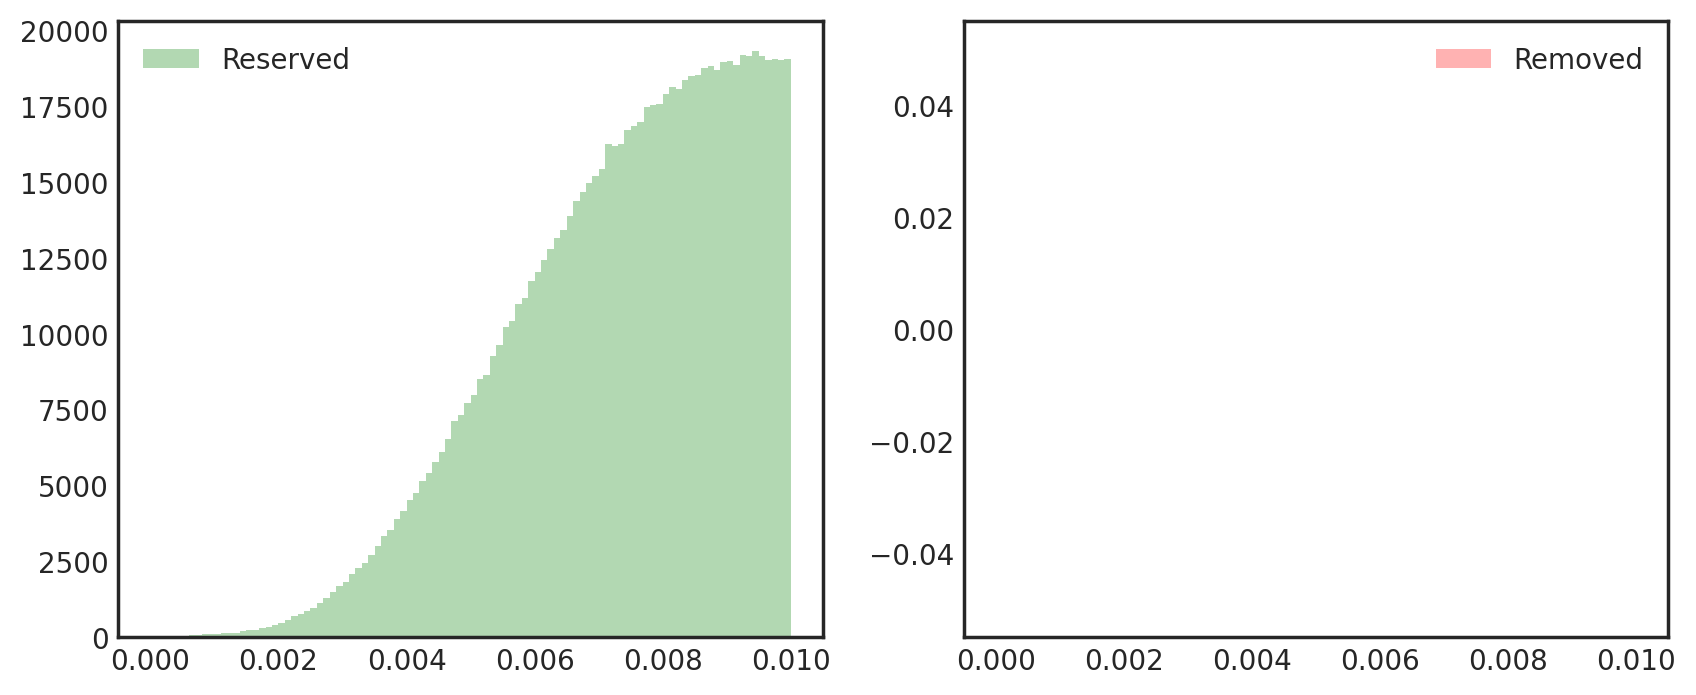

In [36]:
radius_reserved = model.get_scaling[~grad_mask.squeeze(), :2].norm(dim=1)
radius_removed = model.get_scaling[grad_mask.squeeze(), :2].norm(dim=1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(radius_reserved.cpu().numpy(), bins=100, range=(0, 0.01), alpha=0.3, color='g', label="Reserved");
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(radius_removed.cpu().numpy(), bins=100, range=(0, 0.01), alpha=0.3, color='r', label="Removed");
plt.legend()
plt.show()

# scaling_reserved = max_radii2D[~grad_mask.squeeze() & (results["radii"]>0)]
# scaling_removed = max_radii2D[grad_mask.squeeze() & (results["radii"]>0)]
# print(f"Average scaling of reserved gaussians: {scaling_reserved.mean(dim=0)}")
# print(f"Average scaling of removed gaussians: {scaling_removed.mean(dim=0)}")